## Library installation

In [ ]:
!pip install -q "flwr[simulation]" flwr-datasets

In [ ]:
!pip install transformers

In [ ]:
!pip install torch==1.13.1+cpu torchvision==0.14.1+cpu --extra-index-url https://download.pytorch.org/whl/cpu

In [ ]:
!pip install matplotlib

In [ ]:
!pip install scikit-learn

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn

import tqdm

from datasets import Dataset, DatasetDict
from flwr_datasets.partitioner import IidPartitioner

from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, Subset

from transformers import AutoModel, AutoTokenizer

## Data preprocessing

In [2]:
label_mapping = {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2,
}

In [3]:
training_data = pd.read_csv("data/twitter_training.csv")
training_data = training_data[training_data.label != "Irrelevant"].drop(columns=["tweet_id", "entity"]).dropna()
training_data["label"] = training_data["label"].map(label_mapping)
training_ds = Dataset.from_pandas(training_data, preserve_index=False)

validation_data = pd.read_csv("data/twitter_validation.csv")
validation_data = validation_data[validation_data.label != "Irrelevant"].drop(columns=["tweet_id", "entity"]).dropna()
validation_data["label"] = validation_data["label"].map(label_mapping)
validation_ds = Dataset.from_pandas(validation_data, preserve_index=False)

In [4]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [5]:
training_ds = training_ds.map(
    lambda s, tok: {
        "ids": (encoded := tok(s["text"], truncation=True, padding=True))["input_ids"],
        "attention_mask": encoded["attention_mask"],
    },
    fn_kwargs={"tok": tokenizer},
)
validation_ds = validation_ds.map(
    lambda s, tok: {
        "ids": (encoded := tok(s["text"], truncation=True, padding=True))["input_ids"],
        "attention_mask": encoded["attention_mask"],
    },
    fn_kwargs={"tok": tokenizer},
)

Map:   0%|          | 0/47636 [00:00<?, ? examples/s]

Map:   0%|          | 0/11879 [00:00<?, ? examples/s]

In [6]:
training_ds = training_ds.with_format(type="torch", columns=["ids", "label", "attention_mask"])
validation_ds = validation_ds.with_format(type="torch", columns=["ids", "label", "attention_mask"])

In [7]:
DatasetDict({"train": training_ds, "test": validation_ds})

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'ids', 'attention_mask'],
        num_rows: 47636
    })
    test: Dataset({
        features: ['label', 'text', 'ids', 'attention_mask'],
        num_rows: 11879
    })
})

In [8]:
def get_data_loader(dataset: Dataset, batch_size: int, pad_index, shuffle=False) -> DataLoader:
    def collate_fn(batch):
        batch_ids = nn.utils.rnn.pad_sequence([i["ids"] for i in batch], padding_value=pad_index, batch_first=True)
        batch_label = torch.stack([i["label"] for i in batch])
        batch_mask = nn.utils.rnn.pad_sequence([i["attention_mask"] for i in batch], padding_value=pad_index, batch_first=True)
        
        return {
            "ids": batch_ids,
            "label": batch_label,
            "attention_mask": batch_mask,
        }
    
    dl = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle
    )
    
    return dl

training_dl = get_data_loader(training_ds, 32, tokenizer.pad_token_id, shuffle=True)
validation_dl = get_data_loader(validation_ds, 32, tokenizer.pad_token_id)

## Model definition

In [9]:
class Transformer(nn.Module):
    def __init__(self, transformer, num_classes: int, freeze: bool):
        super().__init__()
        
        self.transformer = transformer
        self.fc = nn.Linear(transformer.config.hidden_size, num_classes)
        self.dropout = nn.Dropout(0.3)
        
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    
    def forward(self, ids: torch.Tensor, attention_mask: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        output = self.transformer(ids, attention_mask=attention_mask, output_attentions=True)
        pooled_mean = torch.mean(output.last_hidden_state, dim=1)
        cls_hidden = self.dropout(pooled_mean)
        prediction = self.fc(cls_hidden)

        return prediction, output.attentions

In [10]:
tf = AutoModel.from_pretrained("distilbert-base-uncased")

model = Transformer(tf, num_classes=3, freeze=False)

## Loading from backup
### Checkpoint loading

In [ ]:
checkpoint = torch.load("model/checkpoint.pth")

In [ ]:
model.load_state_dict(checkpoint["model_state_dict"])

### Trained model loading

In [ ]:
model.load_state_dict(torch.load("model/trained_model.pth", weights_only=True))

## Model configuration

In [11]:
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 66365187


In [12]:
criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
criterion = criterion.to(device)

print(model)

Transformer(
  (transformer): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_

## Training and evaluation

In [13]:
def get_accuracy(prediction, label):
    predicted_classes = prediction.argmax(dim=-1).cpu().numpy()
    actual_labels = label.cpu().numpy()
    
    return accuracy_score(actual_labels, predicted_classes)

def get_precision(prediction, label):
    predicted_classes = prediction.argmax(dim=-1).cpu().numpy()
    actual_labels = label.cpu().numpy()
    
    return precision_score(actual_labels, predicted_classes, average="macro", zero_division=0)

def train(net: Transformer, data_loader: DataLoader, optimizer: torch.optim.Optimizer) -> tuple[np.float64, np.float64, np.float64]:
    net.train()
    
    batch_losses = []
    batch_accuracies = []
    batch_precisions = []
    
    for batch in tqdm.tqdm(data_loader, desc="Training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        
        prediction, _ = net(ids, attention_mask)
        
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        precision = get_precision(prediction, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
        batch_accuracies.append(accuracy)
        batch_precisions.append(precision.item())
        
    return np.mean(batch_losses), np.mean(batch_accuracies), np.mean(batch_precisions)

def test(net: Transformer, data_loader: DataLoader) -> tuple[np.float64, np.float64, np.float64]:
    net.eval()
    
    batch_losses = []
    batch_accuracies = []
    batch_precisions = []
    
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="Evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            prediction, _ = net(ids, attention_mask)
            
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            precision = get_precision(prediction, label)
            
            batch_losses.append(loss.item())
            batch_accuracies.append(accuracy)
            batch_precisions.append(precision.item())
            
    return np.mean(batch_losses), np.mean(batch_accuracies), np.mean(batch_precisions)

def run_centralized(
        training_loader: DataLoader,
        validation_loader: DataLoader,
        epochs: int,
        learning_rate: float,
        save_checkpoints: bool,
        first_epoch: int = 0,
        optimizer_state_dict = None,
) -> dict[str, dict[str, list[np.float64]]]:
    train_losses = []
    train_accuracies = []
    train_precisions = []

    test_losses = []
    test_accuracies = []
    test_precisions = []
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    if optimizer_state_dict:
        optimizer.load_state_dict(optimizer_state_dict)

    for epoch in range(first_epoch, epochs):
        print(f"Training epoch #{epoch + 1}:")
        
        train_loss, train_accuracy, train_precision = train(model, training_loader, optimizer)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_precisions.append(train_precision)

        print(f"{train_loss = }")
        print(f"{train_accuracy = }")
        print(f"{train_precision = }")

        test_loss, test_accuracy, test_precision = test(model, validation_loader)
        
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        test_precisions.append(test_precision)

        print(f"{test_loss = }")
        print(f"{test_accuracy = }")
        print(f"{test_precision = }")
        
        if save_checkpoints:
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train": {"loss": train_losses, "accuracy": train_accuracies, "precision": train_precisions},
                "test": {"loss": test_losses, "accuracy": test_accuracies, "precision": test_precisions},
            }, "model/checkpoint.pth")
            
    return {
        "train": {"loss": train_losses, "accuracy": train_accuracies, "precision": train_precisions},
        "test": {"loss": test_losses, "accuracy": test_accuracies, "precision": test_precisions},
    }

In [14]:
n = 5
lr = 1e-6

In [15]:
metrics = run_centralized(
    training_dl,
    validation_dl,
    epochs=n,
    learning_rate=lr,
    save_checkpoints=True,
    #first_epoch=checkpoint["epoch"],
    #optimizer_state_dict=checkpoint["optimizer_state_dict"],
)

Training epoch #1:


Training...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1489/1489 [1:04:04<00:00,  2.58s/it]


train_loss = 0.8947761978296084
train_accuracy = 0.5881841840161182
train_precision = 0.5868349267850386


Evaluating...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 372/372 [04:56<00:00,  1.25it/s]


test_loss = 0.7714189097125043
test_accuracy = 0.6657786098310292
test_precision = 0.6601196160254801
Training epoch #2:


Training...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1489/1489 [1:04:54<00:00,  2.62s/it]


train_loss = 0.7383081041741804
train_accuracy = 0.6850570852921424
train_precision = 0.6828319472010981


Evaluating...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 372/372 [04:57<00:00,  1.25it/s]


test_loss = 0.7168043009055558
test_accuracy = 0.7003888248847927
test_precision = 0.6971784300343632
Training epoch #3:


Training...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1489/1489 [1:04:54<00:00,  2.62s/it]


train_loss = 0.6875752029081093
train_accuracy = 0.7121893888515782
train_precision = 0.7104893312840083


Evaluating...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 372/372 [04:57<00:00,  1.25it/s]


test_loss = 0.6811723019326886
test_accuracy = 0.7170218894009217
test_precision = 0.7136086807419283
Training epoch #4:


Training...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1489/1489 [1:04:55<00:00,  2.62s/it]


train_loss = 0.6485251619000816
train_accuracy = 0.7291134989926126
train_precision = 0.7267560422851103


Evaluating...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 372/372 [04:57<00:00,  1.25it/s]


test_loss = 0.653518093850023
test_accuracy = 0.7291186635944701
test_precision = 0.7251814378159503
Training epoch #5:


Training...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1489/1489 [1:05:15<00:00,  2.63s/it]


train_loss = 0.6132569726158742
train_accuracy = 0.7455758898589657
train_precision = 0.7429182696940372


Evaluating...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 372/372 [04:57<00:00,  1.25it/s]


test_loss = 0.6283778905548075
test_accuracy = 0.741635464669739
test_precision = 0.7356090481097763


In [16]:
torch.cuda.empty_cache()

### Predictions on 10 random samples

In [24]:
reverse_mapping = {v: k for k, v in label_mapping.items()}

random_indices = random.sample(range(0, len(validation_ds)), 10)

texts = [validation_ds['text'][i] for i in random_indices]
labels = [validation_ds['label'][i].item() for i in random_indices]
predictions = []

prediction_sample = get_data_loader(Subset(validation_ds, random_indices), 1, tokenizer.pad_token_id)

In [26]:
model.eval()

with torch.no_grad():
    i = 0
    
    for batch in prediction_sample:
        ids = batch["ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        prediction, _ = model(ids, attention_mask)
        predicted_class = prediction.argmax(dim=-1)

        predictions.append(predicted_class.item())

In [27]:
for item in list(zip(texts, [reverse_mapping[l] for l in labels], [reverse_mapping[p] for p in predictions])):
    print(item)

("I tried to quit fortnite so there is no other game I could play, tried playing overwatch or titanfall but it's rubber banding so so badly, I cant get every other game since it takes at least 1 month for something to play, and I already played most of my campaign games", 'Negative', 'Negative')
('the stark fact that nothing new is worth opening back up again in the gta is a SCAM. im so mad', 'Negative', 'Negative')
('I feel so bad XBOX OF MEN or whatever its name now.', 'Negative', 'Negative')
('As a Battlefield 4 fan.. I became happy', 'Positive', 'Positive')
('@ VerizonSupport @ Verizon technique damaged the outside of the ventilation pipe today doing renovation.need, which is fixed and paid for by Verizon ASAP, as animals can enter my house through a ventilation tube.', 'Negative', 'Negative')
('Went to HOME DEPOT, long lines of silent fear vapor frozen people waiting to get hidden in!!! Went to LOWES, long line of fear frozen people anxiously waiting to get lost in. This is... not

### Model saving

In [17]:
torch.save(model.state_dict(), "model/trained_model.pth")

### Evaluation graph

In [18]:
epoch_rng = range(1, n + 1)

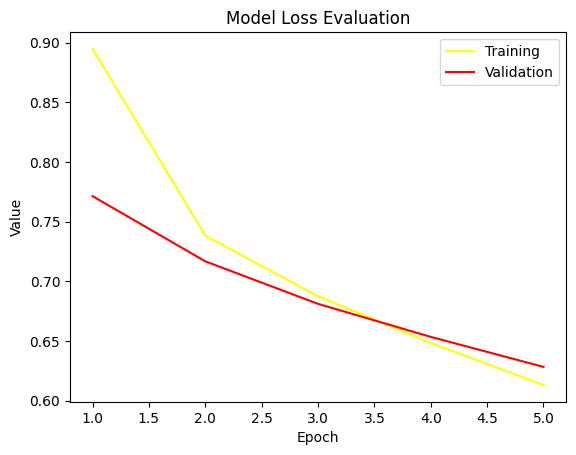

In [28]:
plt.plot(epoch_rng, metrics["train"]["loss"], label="Training", color="yellow")
plt.plot(epoch_rng, metrics["test"]["loss"], label="Validation", color="red")

plt.xlabel("Epoch")
plt.ylabel("Value")

plt.title("Model Loss Evaluation")
plt.legend()
plt.show()

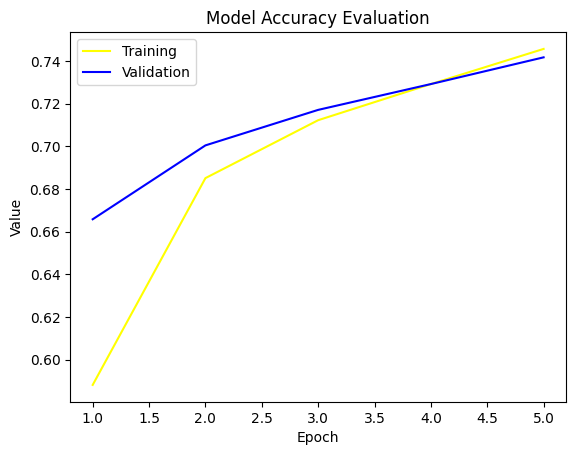

In [29]:
plt.plot(epoch_rng, metrics["train"]["accuracy"], label="Training", color="yellow")
plt.plot(epoch_rng, metrics["test"]["accuracy"], label="Validation", color="blue")

plt.xlabel("Epoch")
plt.ylabel("Value")

plt.title("Model Accuracy Evaluation")
plt.legend()
plt.show()

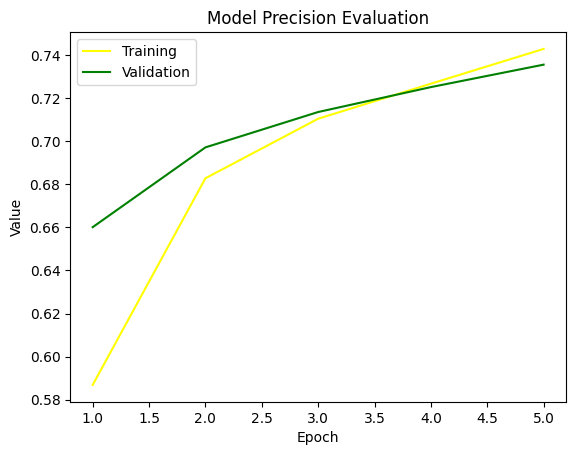

In [30]:
plt.plot(epoch_rng, metrics["train"]["precision"], label="Training", color="yellow")
plt.plot(epoch_rng, metrics["test"]["precision"], label="Validation", color="green")

plt.xlabel("Epoch")
plt.ylabel("Value")

plt.title("Model Precision Evaluation")
plt.legend()
plt.show()